# **XGBoost univariate model for the prediction of meteorological time series data.**

# **XGBoost for forecasting**
*Code used and adapted from reference:*  **https://medium.com/@geokam/time-series-forecasting-with-xgboost-and-lightgbm-predicting-energy-consumption-460b675a9cee**

# LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

# DATA WORK

In [ ]:
# // read the csv file and store it in DataFrame -> data_csv object
path = '/content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING TESIS/TIME-SERIES-Diario-13-23.csv'
# path = '/content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING TESIS/TIME-SERIES-Mensual-86-23.csv'
df = pd.read_csv(path,delimiter=',')
df

,Año,Mes,Dia,Fecha,Tｰ Media,TｰMaxima,TｰMinima,Lluvia,%Humedad
0,2013,Ene,1,1/1/2013,12.038,18.022,7.344,0.956,73.676
1,2013,Ene,2,1/2/2013,12.224,18.000,8.078,3.600,74.553
2,2013,Ene,3,1/3/2013,11.902,17.822,7.667,9.933,76.719
3,2013,Ene,4,1/4/2013,10.906,16.778,7.122,8.800,79.117
4,2013,Ene,5,1/5/2013,11.146,16.267,7.211,4.956,79.746
...,...,...,...,...,...,...,...,...,...
3878,2023,Ago,15,8/15/2023,10.306,18.840,3.220,0.000,62.130
3879,2023,Ago,16,8/16/2023,10.577,19.060,3.260,0.000,60.487
3880,2023,Ago,17,8/17/2023,10.377,18.620,3.200,0.120,59.871
3881,2023,Ago,18,8/18/2023,10.060,17.830,3.580,1.620,62.313


In [ ]:
# Asegúrate de convertir la columna de fecha al formato adecuado
df['Fecha'] = pd.to_datetime(df['Fecha'])
# data.set_index('Fecha', inplace=True)
df = df.rename(columns={"Tｰ Media": "Temp_media", "TｰMaxima": "Temp_max", "TｰMinima": "Temp_min", "Lluvia": "Precipitacion", "%Humedad": "Humedad" })
# all_data = df.drop(["Año", "Mes", "Dia", "Temp_media"], axis=1)
# df = df.drop(["Año", "Mes", "Temp_media", "Temp_min", "Precipitacion", "Humedad"], axis=1) #Humedad
df = df.drop(["Año", "Mes", "Dia","Temp_media", "Temp_min", "Precipitacion", "Humedad"], axis=1) #Humedad
df

,Fecha,Temp_max
0,2013-01-01,18.022
1,2013-01-02,18.000
2,2013-01-03,17.822
3,2013-01-04,16.778
4,2013-01-05,16.267
...,...,...
3878,2023-08-15,18.840
3879,2023-08-16,19.060
3880,2023-08-17,18.620
3881,2023-08-18,17.830


## DATA TRANSFORMATION

In [ ]:
# Eliminar valores nulos generados por el shift
df.dropna(inplace=True)

### DATA FEATURES (LAGS)

In [ ]:
# Crear características de lags
for lag in range(1, 10+1):  # 7 lags (una semana de retraso)
    df[f'Temp_max_lag_{lag}'] = df['Temp_max'].shift(lag)

# Agregar componentes de estacionalidad (mes y día del año)
df['month'] = df['Fecha'].dt.month
df['dayofyear'] = df['Fecha'].dt.dayofyear

In [ ]:
# Eliminar valores nulos generados por el shift
df.dropna(inplace=True)
# Mostrar las primeras filas con las nuevas características
df.head()

,Fecha,Temp_max,Temp_max_lag_1,Temp_max_lag_2,Temp_max_lag_3,Temp_max_lag_4,Temp_max_lag_5,Temp_max_lag_6,Temp_max_lag_7,Temp_max_lag_8,Temp_max_lag_9,Temp_max_lag_10,month,dayofyear
10,2013-01-11,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,18.000,18.022,1,11
11,2013-01-12,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,18.000,1,12
12,2013-01-13,17.480,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,17.822,1,13
13,2013-01-14,17.710,17.480,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,16.778,1,14
14,2013-01-15,17.820,17.710,17.480,18.222,18.344,17.589,17.767,17.967,17.922,17.522,16.267,1,15


# DATA SPLIT

In [ ]:
from sklearn.model_selection import train_test_split

# Definir características y variable objetivo
features = df.drop(columns=['Fecha', 'Temp_max'])
target = df['Temp_max']

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

# Mostrar las dimensiones de los conjuntos de datos
X_train.shape, X_test.shape

((3098, 12), (775, 12))

# MODEL BUILD

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree', # Utiliza árboles de decisión.
    objective='reg:squarederror',
    # early_stopping_rounds=50,

    n_estimators=1000,  # Ajustado para un aprendizaje más rápido
    max_depth=150,  # Más profundo para capturar más complejidad
    # learning_rate=0.01,  # Aumentado para un aprendizaje más rápido
    subsample=0.7,  # Usar solo 80% de las muestras para cada árbol
    colsample_bytree=0.7,  # Usar solo 80% de las características para cada árbol
    gamma=0.1,  # Prueba también con valores como 0.1, 0.2
    reg_alpha=0,  # Regularización L1
    reg_lambda=1,  # Regularización L2

    eval_metric="rmse"
)

eval_set = [(X_train, y_train), (X_test, y_test)]

In [ ]:
# Entrenar el modelo
model.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_test, y_test)], verbose=2)

[0]	validation_0-rmse:12.33966	validation_1-rmse:12.82062
[2]	validation_0-rmse:6.25016	validation_1-rmse:6.63550
[4]	validation_0-rmse:3.37978	validation_1-rmse:3.81189
[6]	validation_0-rmse:2.01561	validation_1-rmse:2.63339
[8]	validation_0-rmse:1.29851	validation_1-rmse:2.23103
[10]	validation_0-rmse:0.89405	validation_1-rmse:2.09040
[12]	validation_0-rmse:0.63945	validation_1-rmse:2.03911
[14]	validation_0-rmse:0.47665	validation_1-rmse:2.01789
[16]	validation_0-rmse:0.36865	validation_1-rmse:2.01680
[18]	validation_0-rmse:0.29994	validation_1-rmse:2.00812
[20]	validation_0-rmse:0.25141	validation_1-rmse:2.01015
[22]	validation_0-rmse:0.21713	validation_1-rmse:2.01019
[24]	validation_0-rmse:0.19503	validation_1-rmse:2.01423
[26]	validation_0-rmse:0.18147	validation_1-rmse:2.01219
[28]	validation_0-rmse:0.18068	validation_1-rmse:2.01257
[30]	validation_0-rmse:0.17679	validation_1-rmse:2.01213
[32]	validation_0-rmse:0.17433	validation_1-rmse:2.01241
[34]	validation_0-rmse:0.16910	val

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=150, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## MODEL PREDICTION

In [ ]:
# # Predecir el conjunto de prueba
# y_pred = model.predict(X_test)

# Predicciones
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

### EVALUATION METRICS

In [ ]:
# Calcular el MSE
mse = mean_squared_error(y_test, y_test_pred)
# Calcular el RMSE
rmse = np.sqrt(mse)
# Calcular R-cuadrado (coefficient of determination)
r2 = r2_score(y_test, y_test_pred)
# Calcular el MAE
mae = mean_absolute_error(y_test, y_test_pred)

# Imprimir las métricas
print(f'MSE: {mse:.5f}')
print(f'RMSE: {rmse:.5f}')
print(f'R² Score: {r2:.5f}')
print(f'MAE: {mae:.5f}')

MSE: 4.05980
RMSE: 2.01489
R² Score: 0.16901
MAE: 1.53382


# GRAPHICS

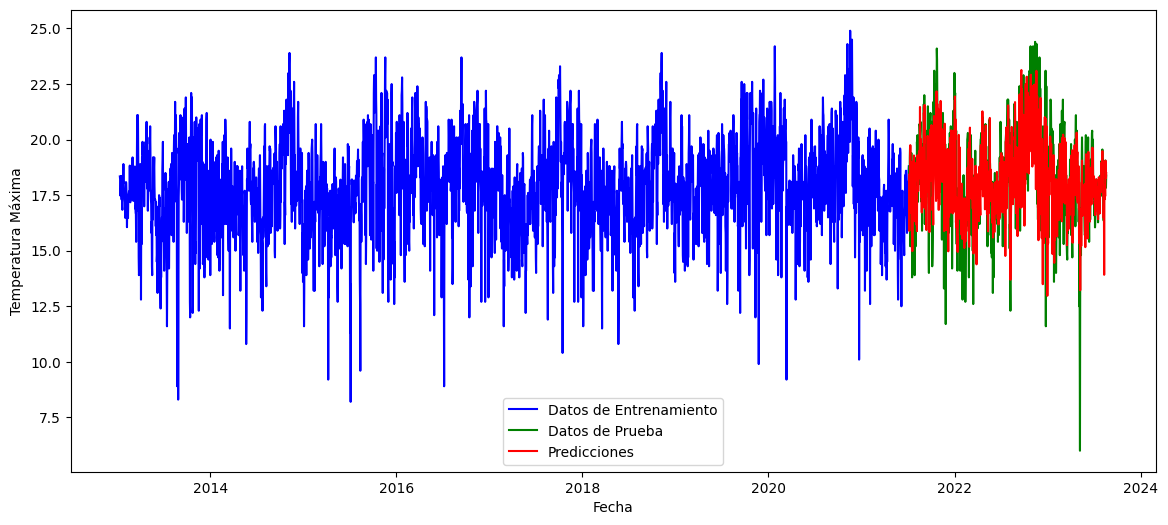

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df['Fecha'].iloc[:len(X_train)], y_train, label='Datos de Entrenamiento', color='blue')
plt.plot(df['Fecha'].iloc[len(X_train):], y_test, label='Datos de Prueba', color='green')
plt.plot(df['Fecha'].iloc[len(X_train):], y_test_pred, label='Predicciones', color='red')
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima')
# plt.title('Comparación de Datos Reales y Predicciones')
plt.legend()
# plt.grid()
plt.show()

## FUTURE PREDICTIONS

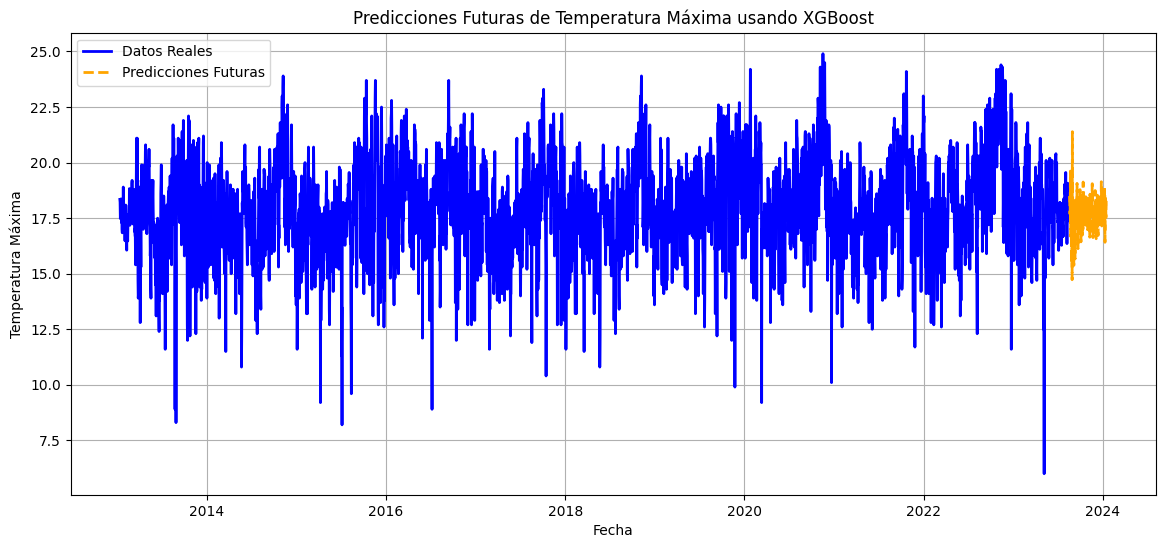

In [ ]:
# Número de días a predecir en el futuro
future_days = 150

# Crear un DataFrame para las predicciones futuras
future_dates = pd.date_range(start=df['Fecha'].iloc[-1] + pd.Timedelta(days=1), periods=future_days, freq='D')
# future_dates = pd.date_range(start=df['Fecha'].iloc[-1] + pd.Timedelta(days=1), periods=future_days, freq='M')
future_df = pd.DataFrame({'Fecha': future_dates})

# Usar las últimas observaciones como características para predecir el futuro
# Asegúrate de que estás obteniendo el número correcto de lags (en este caso, 7)
last_observations = df.drop(columns=['Fecha', 'Temp_max']).iloc[-1].values  # Cambiado de [-7:] a [-1]

# Inicializar una lista para almacenar las predicciones futuras
future_predictions = []

# Iterar sobre el número de días a predecir
for i in range(future_days):
    # Crear un DataFrame temporal con las características para predecir
    # Asegúrate de que la forma de los datos coincida con lo que espera el modelo
    temp_df = pd.DataFrame([last_observations], columns=features.columns)

    # Predecir el próximo valor
    future_pred = model.predict(temp_df)[0]

    # Agregar la predicción al DataFrame futuro
    future_df.loc[i, 'Temp_max'] = future_pred

    # Actualizar las observaciones para la siguiente predicción
    last_observations = np.roll(last_observations, -1)  # Rueda los valores para dejar espacio para el nuevo
    last_observations[-1] = future_pred  # Añadir la nueva predicción al final

# Gráfico de las predicciones futuras
plt.figure(figsize=(14, 6))
plt.plot(df['Fecha'], df['Temp_max'], label='Datos Reales', color='blue', linewidth=2)
plt.plot(future_df['Fecha'], future_df['Temp_max'], label='Predicciones Futuras', color='orange', linestyle='dashed', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima')
plt.title('Predicciones Futuras de Temperatura Máxima usando XGBoost')
plt.legend()
plt.grid()
plt.show()